## Get the data

In [20]:
# Download the data and remove first line
!curl -L -o ./Bitstamp_BTCUSD_d.csv https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv
!sed -i '1d' ./Bitstamp_BTCUSD_d.csv

data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  363k  100  363k    0     0   214k      0  0:00:01  0:00:01 --:--:--  214k


## Calculate basic statistics

In [21]:
import numpy as np

data['daily_return'] = data['close'].pct_change()

# Calculate basic statistics
mean_return = data['daily_return'].mean()
std_dev = data['daily_return'].std()
annualized_volatility = std_dev * np.sqrt(365)  # Assuming 365 period


print("Basic Data Information:")
print(f"Mean Daily Return: {mean_return:.6f}")
print(f"Daily Volatility (Standard Deviation): {std_dev:.6f}")
print(f"Annualized Volatility: {annualized_volatility:.6f}")

Basic Data Information:
Mean Daily Return: -0.000781
Daily Volatility (Standard Deviation): 0.037561
Annualized Volatility: 0.717599


In [22]:
# Display data summary
print("\nData Summary:")
print(data.describe())


Data Summary:
               unix                 date           open           high  \
count  3.839000e+03                 3839    3839.000000    3839.000000   
mean   1.582934e+09  2020-02-29 00:00:00   22860.281331   23391.282363   
min    1.417133e+09  2014-11-28 00:00:00     162.000000     212.840000   
25%    1.500034e+09  2017-07-14 12:00:00    2681.795000    2783.310000   
50%    1.582934e+09  2020-02-29 00:00:00   10163.810000   10398.000000   
75%    1.665835e+09  2022-10-15 12:00:00   37263.720000   38232.490000   
max    1.748736e+09  2025-06-01 00:00:00  111742.000000  112000.000000   
std    9.576301e+07                  NaN   26143.812053   26685.679927   

                 low          close    Volume BTC    Volume USD  daily_return  
count    3839.000000    3839.000000  3.839000e+03  3.839000e+03   3838.000000  
mean    22292.045442   22887.492175  9.185161e+06  7.169583e+07     -0.000781  
min       152.400000     162.000000  0.000000e+00  0.000000e+00     -0.224175 

## Simple closing prices line with EMA

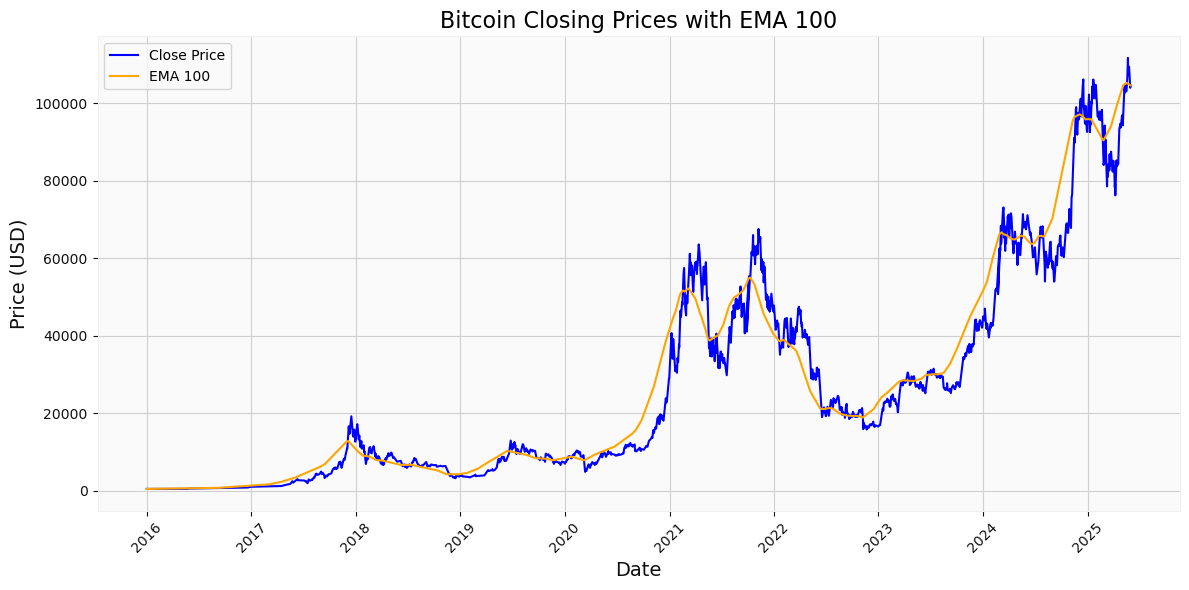

In [23]:
import matplotlib.pyplot as plt

#remove pre 2016
data = data[data['date'] >= '2016-01-01']
data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()

plt.figure(figsize=(12, 6))

# Plot close prices
plt.plot(data['date'], data['close'], label='Close Price', color='blue')

# Plot EMA
plt.plot(data['date'], data['EMA_100'], label='EMA 100', color='orange')

# titles and labels
plt.title('Bitcoin Closing Prices with EMA 100', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Display PSAR, RSI, and EMA

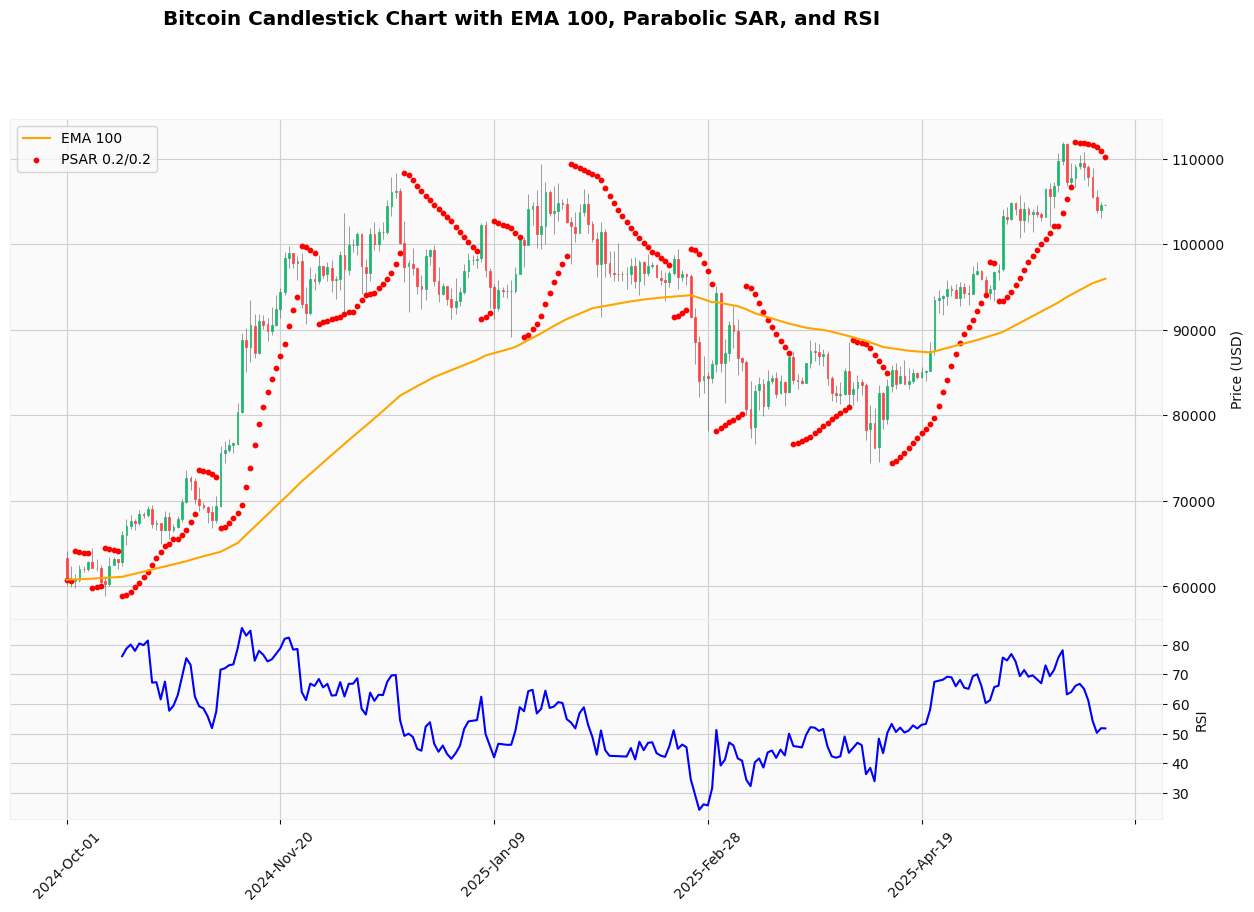

In [24]:
import pandas as pd
import mplfinance as mpf
from ta.trend import PSARIndicator
from ta.momentum import RSIIndicator
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

ema_span = 100  #define the EMA period
psar_step = 0.2 # Default acceleration factor
psar_max = 0.2 # Default maximum acceleration factor

data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')  # .csv file with daily data

# ensure the 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# only dates from specified (for readability)
data = data[data['date'] >= '2024-10-01']

# set'date' column as the index (required for mplfinance)
data.set_index('date', inplace=True)

data = data[::-1]  # Reverse the data order

# calculate EMA
data[f'EMA_{ema_span}'] = data['close'].ewm(span=ema_span, adjust=False).mean()

psar = PSARIndicator(
    high=data['high'],
    low=data['low'],
    close=data['close'],
    step=0.02,
    max_step=0.2
)
data['psar'] = psar.psar()

# calculate RSI
rsi_period = 14  # Typical RSI period is 14
rsi = RSIIndicator(close=data['close'], window=rsi_period)
data['RSI'] = rsi.rsi()

# prepare the additional EMA, PSAR overlays, and RSI subplot for mplfinance
additional_plots = [
    mpf.make_addplot(data[f'EMA_{ema_span}'], color='orange', width=1.5, label=f'EMA {ema_span}'),
    mpf.make_addplot(data['psar'], color='red', scatter=True, markersize=10, label=f'PSAR {psar_step}/{psar_max}'),
    mpf.make_addplot(data['RSI'], panel=1, color='blue', width=1.5, ylabel='RSI')  # Add RSI as a subplot
]

# plot candlesticks
fig, axlist = mpf.plot(
    data,
    type='candle',
    style='yahoo',
    addplot=additional_plots,
    title=f'Bitcoin Candlestick Chart with EMA {ema_span}, Parabolic SAR, and RSI',
    ylabel='Price (USD)',
    figsize=(16, 10),
    volume=False,  # Set to True if you want a volume subplot
    returnfig=True  # Required to modify legend position
)

# adjust legend position to upper left
for ax in axlist:
    handles, labels = ax.get_legend_handles_labels()
    if handles:  # Check if there are any handles to avoid errors
        ax.legend(handles, labels, loc='upper left')  # Move legend to top left



## Save the chart to file

In [25]:
# save output .png
output_file = f'bitcoin_candlestick_chart_ema{ema_span}_rsi_with_legend.png'
fig.savefig(output_file)

print(f"Chart saved as {output_file}")


Chart saved as bitcoin_candlestick_chart_ema100_rsi_with_legend.png
